### Welcome to Deep Learning with PyTorch Series of project 

- Deep Learning with PyTorch : Build a Neural Network 
- **Deep Learning with PyTorch : Convolutional Neural Network**
- Deep Learning with PyTorch : Neural Style Transfer
- Many more coming

# Deep Learning with PyTorch : Build a Convolutional Neural Network

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

## Task 1 : Load CIFAR-10 Dataset

![](cifar-10.png)

PyTorch transforms : https://pytorch.org/docs/stable/torchvision/transforms.html
- **For CIFAR-10 Dataset Channel mean is 0.4914, 0.4822, 0.4465**
- **Channel wise Standard Deviation is 0.2470, 0.2435, 0.2616**

In [3]:
from torchvision import transforms as T, datasets

* ToTensor() : converts numpy or PIL images to tensor. It also converts your image dimension to C x H x W because in pytorch for network input channel should be first 

* Normalize() : Takes channel wise mean-list and channel wise standard deviation-list

In [4]:
data_transforms = T.Compose([
    T.ToTensor(), # H x W x C-> C x H x W
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

#### Parameters in datasets submodule

* data_path
* train : True (to load train set) or False (to load test set)
* download : True (to download) or False
* transform : to apply transformation on data


CIFAR-10 consists of 60,000 tiny 32 x 32 x 3(RGB) images, labeled with an interger corresponding to 1 of 10 : classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
train_ds = datasets.CIFAR10('cifar10/', train=True, download = False, transform = data_transforms)
test_ds = datasets.CIFAR10('cifar10/', train=False, download = False, transform = data_transforms)

In [6]:
print('Size of train set {}'.format(len(train_ds)))
print('Size of test set {}'.format(len(test_ds)))

Size of train set 50000
Size of test set 10000


## Task 2 : Plot examples from dataset

In [12]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

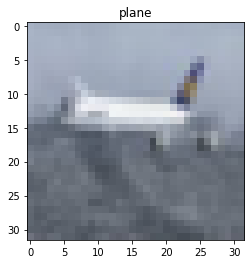

In [17]:
index = 199
image, label = train_ds[index]
image = image.permute(1,2,0) # C(0) x H(1) x W(2)

#denormalizing the image
image = image * torch.Tensor([0.2470, 0.2435, 0.2616]) + torch.Tensor([0.4914, 0.4822, 0.4465])
plt.imshow(image)
plt.title(classes[label]);

## Task 3 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader, random_split

In [19]:
train_dataset, valid_dataset = random_split(train_ds, (45000, 5000))

In [21]:
trainLoader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validLoader = DataLoader(valid_dataset, batch_size = 64, shuffle = True)
testLoader = DataLoader(test_ds, batch_size = 64, shuffle = True)

In [23]:
print("total batches created in Train loader: {}".format(len(trainLoader)))
print("total batches created in Valid loader: {}".format(len(validLoader)))
print("total batches created in Test loader: {}".format(len(testLoader)))
print("size of train dataset {}".format(len(trainLoader.dataset)))
print("size of valid dataset {}".format(len(validLoader.dataset)))
print("size of test dataset {}".format(len(testLoader.dataset)))

total batches created in Train loader: 704
total batches created in Valid loader: 79
total batches created in Test loader: 157
size of train dataset 45000
size of valid dataset 5000
size of test dataset 10000


In [24]:
detailer = iter(trainLoader)

images, labels = detailer.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


## Task 4 : Create Convolutional Neural Network 

In [25]:
from torch import nn
import torch.nn.functional as F


k : kernel_size or filters 
<br>
p : padding 
<br>
s : stride 
<br>
W : Width 
<br>
H : Height 

\begin{equation*}
For Same padding = \frac{k - 1}{2} \\
\end{equation*}

\begin{equation*}
W[next] = \frac{W[previous] + 2p - k}{s} + 1 \\
\end{equation*}

\begin{equation*}
H[next] = \frac{H[previous] + 2p - k}{s} + 1 \\
\end{equation*}

In [ ]:
'''
3 x 32 x 32 (input)

       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1
       V activation = relu 
       
16 x 32 x 32

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
16 x 15 x 15

       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2
       V activation = relu
       
32 x 15 x 15 

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
32 x 8 x 8

       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3
       V activation = relu 
       
64 x 8 x 8

       | k = (2,2), s = 2 , operation = MaxPooling #maxpool
       V

64 x 4 x  4
    
       |  operation = Flatten
       V
500

       |  linear,activation = relu #linear1
       V

128
       |  linear,activation = relu #linear2
       V

10  linear, activation = log_softmax #linear3
'''

In [36]:
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 16,
                               kernel_size = (3,3), padding =1, stride = 1)
        
        self.conv_2 = nn.Conv2d(in_channels = 16, out_channels = 32,
                               kernel_size = (3,3), padding =1, stride = 1)
        
        self.conv_3 = nn.Conv2d(in_channels = 32, out_channels = 64,
                               kernel_size = (3,3), padding =1, stride = 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size =(2,2), stride = 2)
        self.linear_1 = nn.Linear(in_features = 1024, out_features = 500)
        self.linear_2 = nn.Linear(in_features = 500, out_features = 128)
        self.linear_3 = nn.Linear(in_features = 128, out_features = 10)
        
        
    def forward(self, images):
        
        #images : 3 x 32 x32
        
        a1 = self.maxpool(F.relu(self.conv_1(images)))
        a2 = self.maxpool(F.relu(self.conv_2(a1)))
        a3 = self.maxpool(F.relu(self.conv_3(a2)))
        
        a3 = a3.view(a3.shape[0], -1) #(bs, 64, 4, 4) -> (bs, 64*4*4) -> (bs, 1024)
        
        a4 = F.relu(self.linear_1(a3))
        
        a5 = F.relu(self.linear_2(a4))
        
        a6 = F.log_softmax(self.linear_3(a5))
        
        return(a6)

In [37]:
model = MyModel()
model

MyModel(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=500, bias=True)
  (linear_2): Linear(in_features=500, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=10, bias=True)
)

In [38]:
from torchsummary import summary

In [39]:
summary(model, input_size= (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 500]         512,500
            Linear-8                  [-1, 128]          64,128
            Linear-9                   [-1, 10]           1,290
Total params: 601,502
Trainable params: 601,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.29
Estimated Total Size (MB): 2.58
-------------------------------------------

/home/rhyme/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Task 5 : Training loop

In [40]:
from torch import optim
from utils import multiclass_accuracy
from tqdm import tqdm

criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 10

In [45]:
for i in range(epochs):
    
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0
    
    model.train()
    
    for images, labels in tqdm(trainLoader):
        
        logps = model(images) #output ps
        
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #w = w - lr*dw
        
        train_loss += loss.item()
        ps = torch.exp(logps) #log_softmax -> softmax
        train_acc += multiclass_accuracy(ps,labels)
        
    model.eval() 
    
    for images, labels in tqdm(validLoader):
        
        logps = model(images)
        logs = criterion(logps, labels)
        
        valid_loss += loss.item()
        ps = torch.exp(logps)
        valid_acc += multiclass_accuracy(ps, labels)
        
    avg_train_loss = train_loss/len(trainLoader)
    avg_valid_loss = valid_loss/len(validLoader)
    avg_train_acc = train_acc/len(trainLoader)
    avg_valid_acc = valid_acc/len(validLoader)

    print("Epoch: {} Train loss: {: .4f} Train Acc : {:.4f}".format(i, avg_train_loss, avg_train_acc))
    print("Epoch: {} Valid loss: {: .4f} Valid Acc : {:.4f}".format(i, avg_valid_loss, avg_valid_acc))

  0%|          | 2/704 [00:00<00:45, 15.29it/s]

Epoch: 0 Train loss:  0.3081 Train Acc : 0.8945
Epoch: 0 Valid loss:  0.1527 Valid Acc : 0.6826


  0%|          | 2/704 [00:00<00:46, 15.01it/s]

Epoch: 1 Train loss:  0.3024 Train Acc : 0.8991
Epoch: 1 Valid loss:  0.2258 Valid Acc : 0.6984


  0%|          | 2/704 [00:00<00:57, 12.17it/s]

Epoch: 2 Train loss:  0.2723 Train Acc : 0.9063
Epoch: 2 Valid loss:  0.7397 Valid Acc : 0.6723


  0%|          | 2/704 [00:00<00:48, 14.57it/s]

Epoch: 3 Train loss:  0.2638 Train Acc : 0.9114
Epoch: 3 Valid loss:  0.0208 Valid Acc : 0.6861


  0%|          | 2/704 [00:00<00:48, 14.35it/s]

Epoch: 4 Train loss:  0.2466 Train Acc : 0.9172
Epoch: 4 Valid loss:  0.0719 Valid Acc : 0.6865


  0%|          | 2/704 [00:00<00:53, 13.01it/s]

Epoch: 5 Train loss:  0.2383 Train Acc : 0.9231
Epoch: 5 Valid loss:  0.3873 Valid Acc : 0.6792


  0%|          | 2/704 [00:00<00:46, 15.06it/s]

Epoch: 6 Train loss:  0.2298 Train Acc : 0.9252
Epoch: 6 Valid loss:  1.2160 Valid Acc : 0.6907


  0%|          | 2/704 [00:00<00:46, 15.20it/s]

Epoch: 7 Train loss:  0.2323 Train Acc : 0.9246
Epoch: 7 Valid loss:  0.0987 Valid Acc : 0.6784


  0%|          | 2/704 [00:00<00:47, 14.85it/s]

Epoch: 8 Train loss:  0.2063 Train Acc : 0.9335
Epoch: 8 Valid loss:  0.0002 Valid Acc : 0.6794


100%|██████████| 79/79 [00:02<00:00, 28.95it/s]

Epoch: 9 Train loss:  0.2037 Train Acc : 0.9347
Epoch: 9 Valid loss:  0.0066 Valid Acc : 0.6800


## Task 6 : Evaluate model 

In [46]:
from utils import view_classify

In [48]:
test_loss = 0
test_acc = 0

model.eval()

for images, labels in tqdm(testLoader):
        
        logps = model(images)
        logs = criterion(logps, labels)
        
        test_loss += loss.item()
        ps = torch.exp(logps)
        test_acc += multiclass_accuracy(ps, labels)
        

avg_test_loss = test_loss/len(testLoader)
avg_test_acc = test_acc/len(testLoader)

print('Test loss: {:.4f} test Acc: {:.4f}'.format(avg_test_loss, avg_test_acc))
        

100%|██████████| 157/157 [00:06<00:00, 26.00it/s]

Test loss: 0.0066 test Acc: 0.6848


/home/rhyme/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


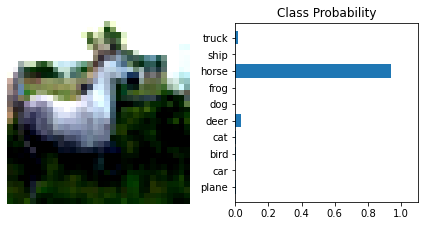

In [50]:
detailer = iter(testLoader)

images, labels = detailer.next()

index = 35
logps = model(images[index].unsqueeze(0)) # (3, 32, 32) -> (1, 3, 32, 32)
ps = torch.exp(logps)

view_classify(images[index], ps)